## Apply variable transformations

In [234]:
import numpy
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
parent_dir = os.path.abspath('../../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from functions.create_panel_dataset import custom_log_transform

In [235]:
foundational_df_no_transformations = pd.read_csv('./output/foundational_no_transformations.csv')
foundational_df_no_transformations_accounts = pd.read_csv('./output/foundational_no_transformations_accounts.csv')

Plot the distribution of the energy variable

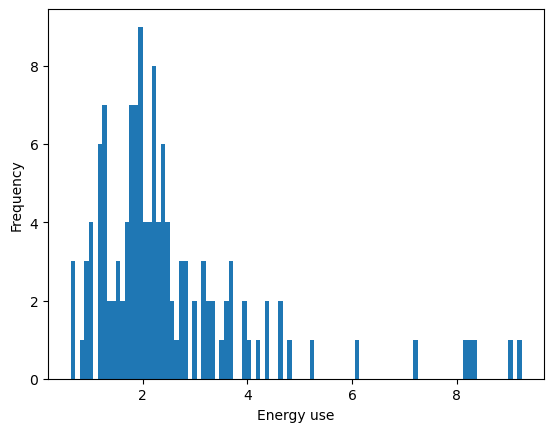

In [236]:
plt.hist(foundational_df_no_transformations["energy"], bins=100)
plt.xlabel("Energy use")
plt.ylabel("Frequency")
plt.show()

1. Transform energy use variable to log

In [237]:
foundational_df_transformed = foundational_df_no_transformations.copy()
min_value = foundational_df_no_transformations["energy"].min()
max_value = foundational_df_no_transformations["energy"].max()
foundational_df_transformed["energy"] = foundational_df_no_transformations["energy"].apply(
    lambda x: custom_log_transform(x, min_value, max_value)
)

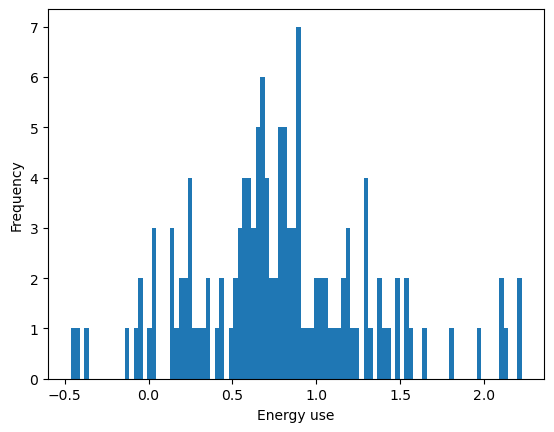

In [238]:
plt.hist(foundational_df_transformed["energy"], bins=100)
plt.xlabel("Energy use")
plt.ylabel("Frequency")
plt.show()

Looks normally distributed now - cool

Same for accounts data

In [239]:
foundational_df_transformed_accounts = foundational_df_no_transformations_accounts.copy()
min_value = foundational_df_no_transformations_accounts["energy"].min()
max_value = foundational_df_no_transformations_accounts["energy"].max()
foundational_df_transformed_accounts["energy"] = foundational_df_no_transformations_accounts["energy"].apply(
    lambda x: custom_log_transform(x, min_value, max_value)
)

2. Transform need satisfaction variables using saturation transformation

First, plot the variables against energy use to see the rough distribution

Note we have two education variables now: education is UNDP expected years of schooling, schoolenr is wdi school enrollment.
The chart looks much better for UNDP, and it doesn't have values over a 100 like with WDI, so we'll go with that.

Text(0.5, 1.0, 'schoolenr vs energy')

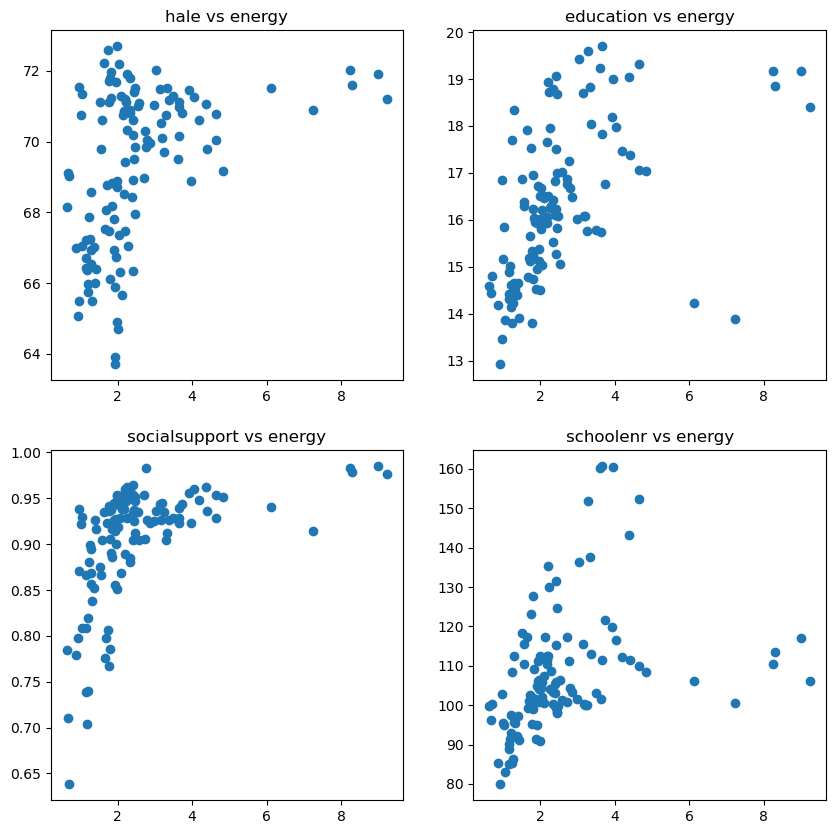

In [240]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(foundational_df_no_transformations["energy"], foundational_df_no_transformations["hale"])
axs[0, 0].set_title('hale vs energy')
axs[0, 1].scatter(foundational_df_no_transformations["energy"], foundational_df_no_transformations["education"])
axs[0, 1].set_title('education vs energy')
axs[1, 0].scatter(foundational_df_no_transformations["energy"], foundational_df_no_transformations["socialsupport"])
axs[1, 0].set_title('socialsupport vs energy')
axs[1, 1].scatter(foundational_df_no_transformations["energy"], foundational_df_no_transformations["schoolenr"])
axs[1, 1].set_title('schoolenr vs energy')

For distributions that look like they get saturated at a certain point, check the maximum values to determine the threshold.

In [241]:
hale_maximum = max(foundational_df_no_transformations["hale"])
socialsupport_maximum = max(foundational_df_no_transformations["socialsupport"])
education_maximum = max(foundational_df_no_transformations["education"])
print(f"Maximum values: hale {hale_maximum}, socialsupport {socialsupport_maximum}, education {education_maximum}")

Maximum values: hale 72.7, socialsupport 0.985, education 19.69990921


Let's also plot the distribution of the variables

Text(0.5, 1.0, 'schoolenr')

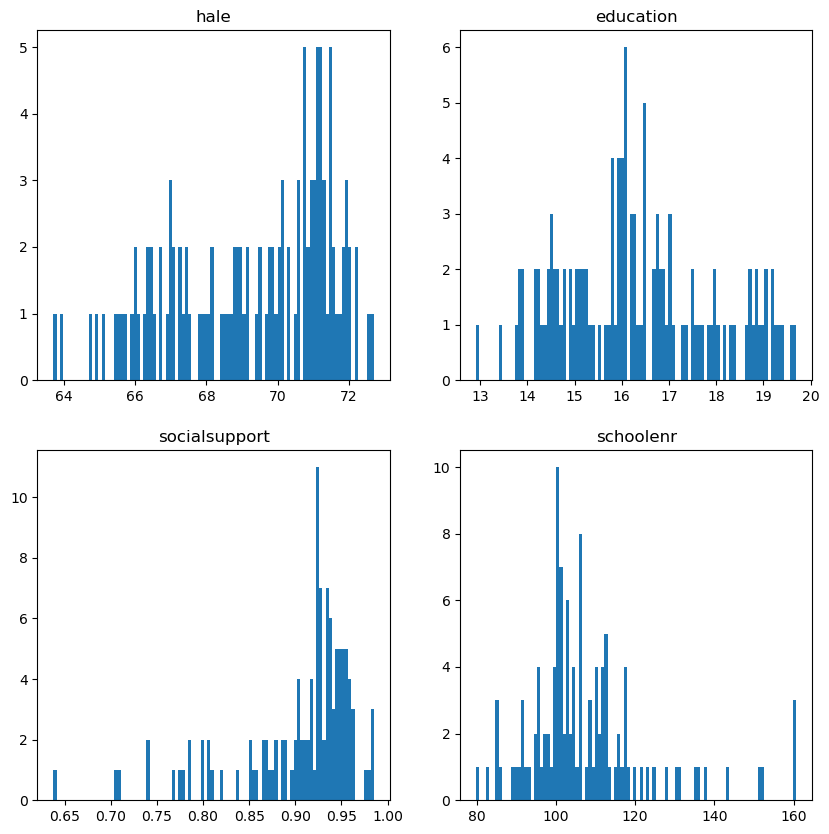

In [242]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(foundational_df_no_transformations["hale"], bins=100)
axs[0, 0].set_title('hale')
axs[0, 1].hist(foundational_df_no_transformations["education"], bins=100)
axs[0, 1].set_title('education')
axs[1, 0].hist(foundational_df_no_transformations["socialsupport"], bins=100)
axs[1, 0].set_title('socialsupport')
axs[1, 1].hist(foundational_df_no_transformations["schoolenr"], bins=100)
axs[1, 1].set_title('schoolenr')

The education is already pretty normally distributed, but the other three are skewed. Let's try log transformation.

In [243]:
need_satisfaction_variables = {
    "hale": hale_maximum ,
    "education": education_maximum,
    "socialsupport": socialsupport_maximum,
    # "lifesatisfaction": 10,
    # "nutrition": 100.3,
    # "sanitation": 100.7,
    # "incomepoverty": 100.3,
    # "energyaccess": 100.7,
}
for col in need_satisfaction_variables.keys():
    if col in foundational_df_no_transformations.columns:
        foundational_df_transformed[col] = foundational_df_no_transformations[col].apply(
            lambda x: numpy.log(need_satisfaction_variables[col] - x) if x is not None and need_satisfaction_variables[col] > x else None
        )
        if foundational_df_transformed[col].isna().any():
            print(
                f"Warning: NaN values found in column {col}. Original values might be too close to or exceed the saturation point."
            )
    else:
        print(f"Warning: Column {col} not found in imputed DataFrame.")

Text(0.5, 1.0, 'schoolenr vs energy')

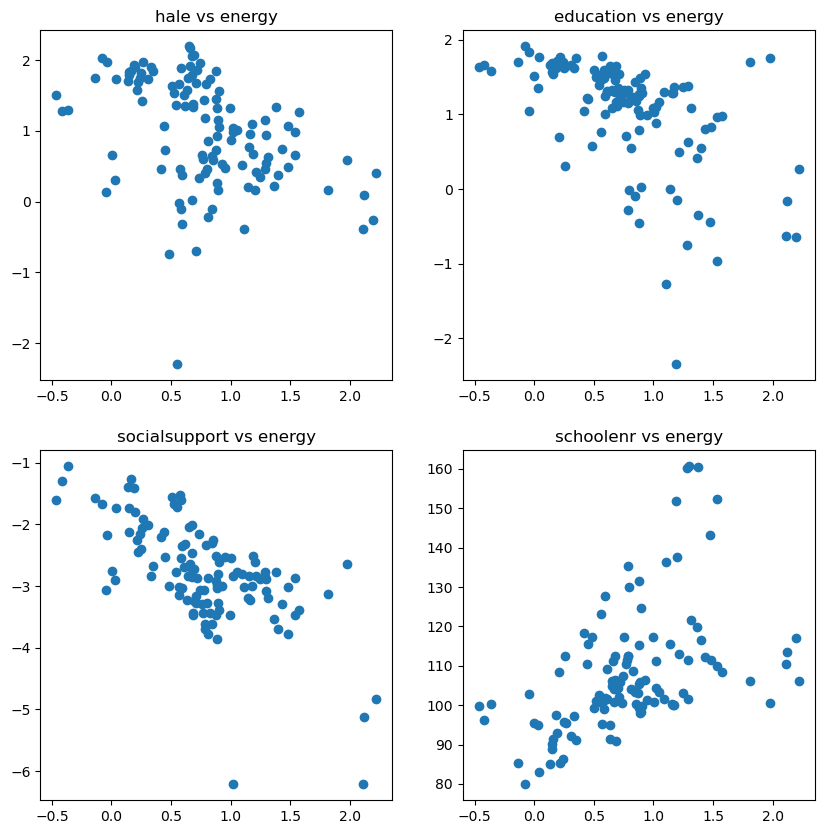

In [244]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(foundational_df_transformed["energy"], foundational_df_transformed["hale"])
axs[0, 0].set_title('hale vs energy')
axs[0, 1].scatter(foundational_df_transformed["energy"], foundational_df_transformed["education"])
axs[0, 1].set_title('education vs energy')
axs[1, 0].scatter(foundational_df_transformed["energy"], foundational_df_transformed["socialsupport"])
axs[1, 0].set_title('socialsupport vs energy')
axs[1, 1].scatter(foundational_df_transformed["energy"], foundational_df_transformed["schoolenr"])
axs[1, 1].set_title('schoolenr vs energy')

Fit a linear regression and plot the residuals to see if they're normally distributed

In [245]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [246]:
def fit_linear_regression(df, x_col, y_col):
    df = df.dropna(subset=[x_col, y_col])
    X = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    mse = mean_squared_error(y, y_pred)
    return reg, mse

In [247]:
def plot_residuals(df, x_col, y_col):
    reg, mse = fit_linear_regression(df, x_col, y_col)
    df = df.dropna(subset=[x_col, y_col])
    X = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values.reshape(-1, 1)
    y_pred = reg.predict(X)
    residuals = y - y_pred
    plt.scatter(X, residuals)
    plt.xlabel(x_col)
    plt.ylabel("Residuals")
    plt.title(f"Residuals for {x_col} vs {y_col}")
    plt.show()
    return residuals

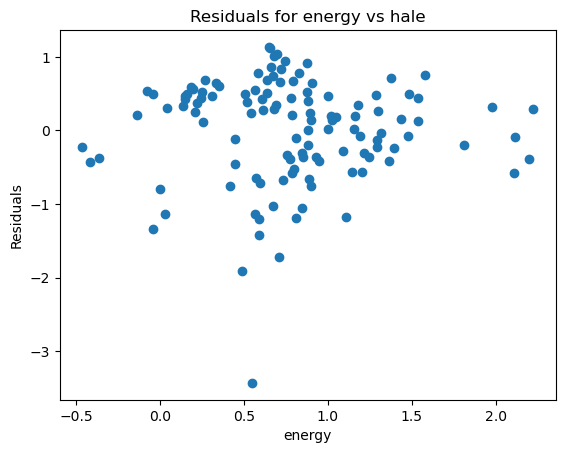

In [248]:
residuals = plot_residuals(foundational_df_transformed, "energy", "hale")

Text(0.5, 1.0, 'schoolenr')

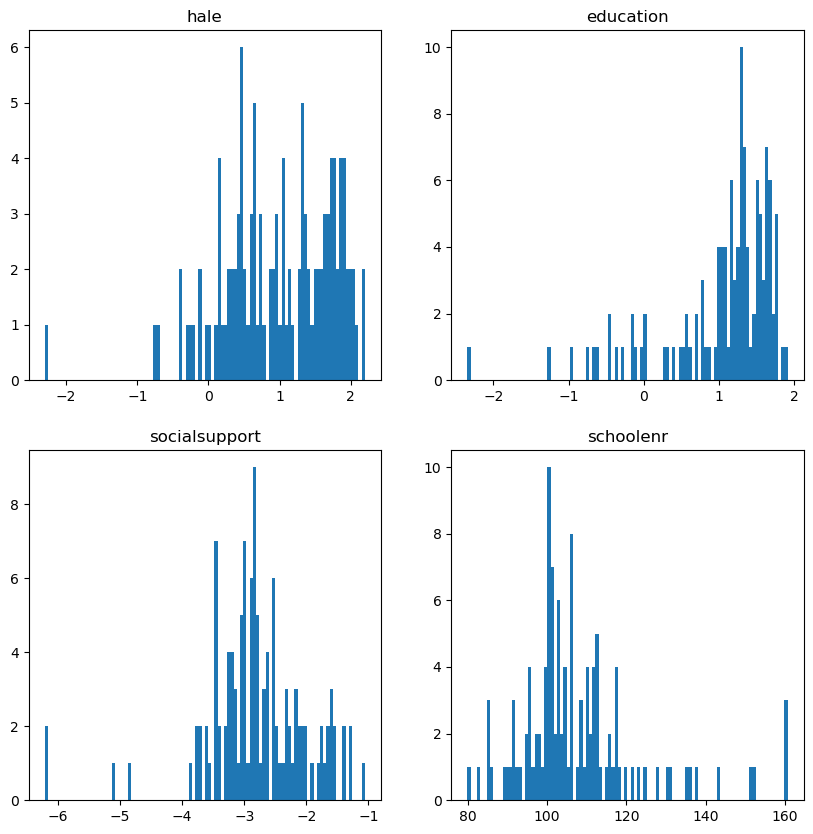

In [249]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(foundational_df_transformed["hale"], bins=100)
axs[0, 0].set_title('hale')
axs[0, 1].hist(foundational_df_transformed["education"], bins=100)
axs[0, 1].set_title('education')
axs[1, 0].hist(foundational_df_transformed["socialsupport"], bins=100)
axs[1, 0].set_title('socialsupport')
axs[1, 1].hist(foundational_df_transformed["schoolenr"], bins=100)
axs[1, 1].set_title('schoolenr')

Doesn't look entirely linear but okay

Same for accounts data

In [250]:
for col in need_satisfaction_variables.keys():
    if col in foundational_df_no_transformations.columns:
        foundational_df_transformed[col] = foundational_df_no_transformations[col].apply(
            lambda x: numpy.log(need_satisfaction_variables[col] - x) if x is not None and need_satisfaction_variables[col] > x else None
        )
        if foundational_df_transformed[col].isna().any():
            print(
                f"Warning: NaN values found in column {col}. Original values might be too close to or exceed the saturation point."
            )
    else:
        print(f"Warning: Column {col} not found in imputed DataFrame.")

Transform provisioning factors using appropriate transformations.
Not applying any transformations to foundational economy variables.

First, plot the variables against energy use to see the rough distribution

Text(0.5, 1.0, 'providential vs energy')

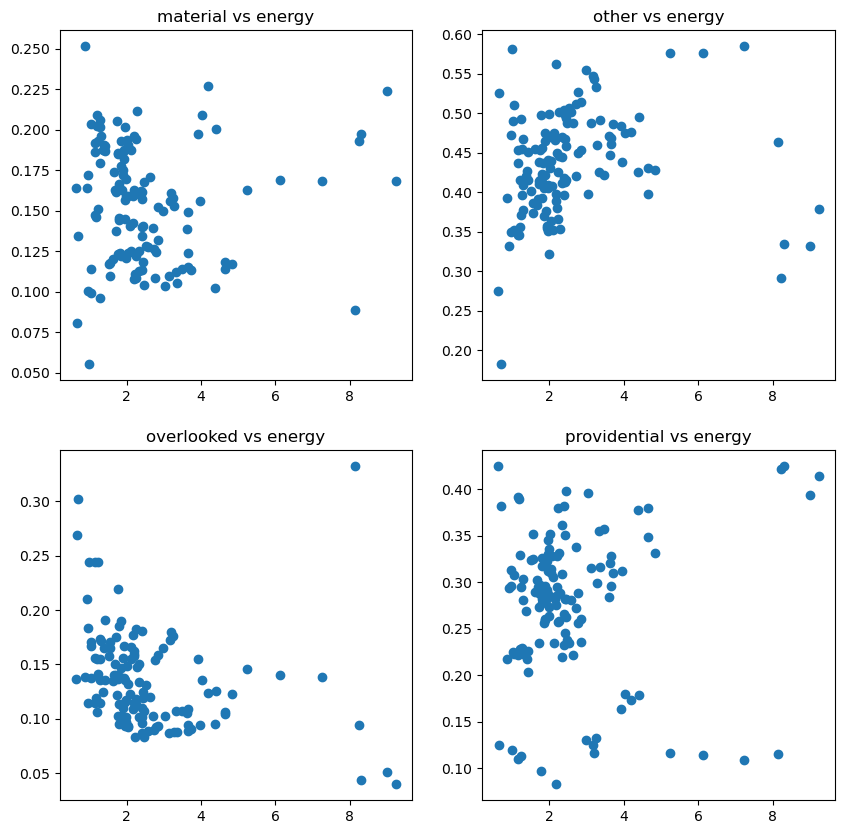

In [251]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(foundational_df_no_transformations["energy"], foundational_df_no_transformations["material"])
axs[0, 0].set_title('material vs energy')
axs[0, 1].scatter(foundational_df_no_transformations["energy"], foundational_df_no_transformations["other"])
axs[0, 1].set_title('other vs energy')
axs[1, 0].scatter(foundational_df_no_transformations["energy"], foundational_df_no_transformations["overlooked"])
axs[1, 0].set_title('overlooked vs energy')
axs[1, 1].scatter(foundational_df_no_transformations["energy"], foundational_df_no_transformations["providential"])
axs[1, 1].set_title('providential vs energy')

In [252]:
provisioning_factor_variables = [
    "material",
    "other",
    "overlooked",
    "providential"
]
for col in provisioning_factor_variables:
    min_value = foundational_df_no_transformations[col].min()
    max_value = foundational_df_no_transformations[col].max()
    foundational_df_transformed[col] = foundational_df_no_transformations[col].apply(
        lambda x: custom_log_transform(x, min_value, max_value)
    )

Same for accounts data

In [254]:
for col in provisioning_factor_variables:
    min_value = foundational_df_no_transformations_accounts[col].min()
    max_value = foundational_df_no_transformations_accounts[col].max()
    foundational_df_transformed_accounts[col] = foundational_df_no_transformations_accounts[col].apply(
        lambda x: custom_log_transform(x, min_value, max_value)
    )

Standardize by subtracting the mean and dividing by the standard deviation.

In [255]:
from sklearn.preprocessing import StandardScaler

In [256]:
variables_to_scale = ['material', 'other', 'overlooked', 'providential', 'energy', 'ladder', 'socialsupport', 'hale', 'freedom', 'charity', 'corruption', 'positive', 'negative', 'education', 'wdi_hale', 'goveffectiveness', 'gini']
scaler = StandardScaler()
foundational_df_transformed[variables_to_scale] = scaler.fit_transform(foundational_df_transformed[variables_to_scale])

Text(0.5, 1.0, 'transformed schoolenr vs energy')

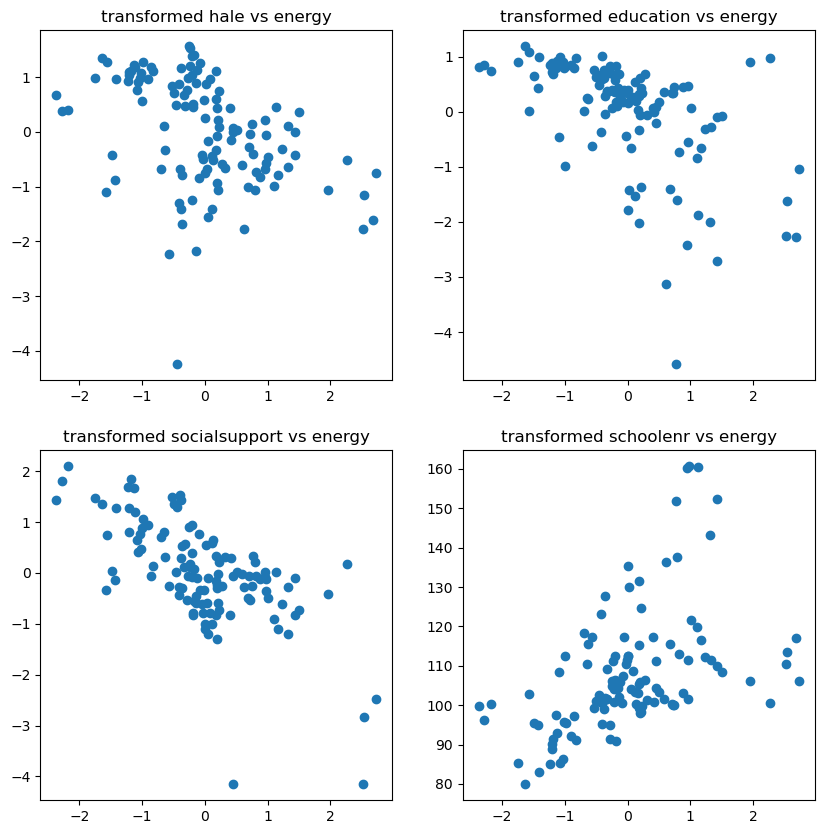

In [257]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(foundational_df_transformed["energy"], foundational_df_transformed["hale"])
axs[0, 0].set_title('transformed hale vs energy')
axs[0, 1].scatter(foundational_df_transformed["energy"], foundational_df_transformed["education"])
axs[0, 1].set_title('transformed education vs energy')
axs[1, 0].scatter(foundational_df_transformed["energy"], foundational_df_transformed["socialsupport"])
axs[1, 0].set_title('transformed socialsupport vs energy')
axs[1, 1].scatter(foundational_df_transformed["energy"], foundational_df_transformed["schoolenr"])
axs[1, 1].set_title('transformed schoolenr vs energy')

Same for accounts data

In [258]:
scaler_accounts = StandardScaler()
foundational_df_transformed_accounts[variables_to_scale] = scaler_accounts.fit_transform(foundational_df_transformed_accounts[variables_to_scale])

In [259]:
scaler_df = pd.DataFrame({'variable': variables_to_scale, 'scale': scaler.scale_, 'mean': scaler.mean_})
scaler_df.to_csv('./output/scaler_values.csv', index=False)

In [260]:
scaler_df_accounts = pd.DataFrame({'variable': variables_to_scale, 'scale': scaler_accounts.scale_, 'mean': scaler_accounts.mean_})
scaler_df_accounts.to_csv('./output/scaler_values_accounts.csv', index=False)

In [261]:
foundational_df_transformed.head()

,geo,TIME_PERIOD,material,other,overlooked,providential,energy,ladder,socialsupport,hale,freedom,charity,corruption,positive,negative,schoolenr,wdi_hale,education,goveffectiveness,gini
0,AL,2012,0.324410,-2.557666,0.041156,1.808007,-2.368645,-0.980589,1.429134,0.683156,-1.354450,-1.011505,0.647092,-1.127141,0.202938,99.700272,-0.360672,0.807093,-1.797876,-0.685966
1,AL,2016,-0.517182,-4.211705,3.545856,1.316092,-2.184553,-2.077999,2.097533,0.409916,-0.444514,-0.021611,0.863043,-0.977443,0.935614,100.219978,-0.096066,0.748027,-1.335701,0.464768
2,AL,2020,-2.087624,1.354344,2.896553,-2.020952,-2.283013,-1.139873,1.815434,0.374253,-0.273901,0.129167,0.822297,-1.020214,0.116740,96.167473,-0.718024,0.843373,-1.596241,-0.588031
3,AT,2008,0.152692,1.459620,0.929579,-1.900301,0.746746,0.855018,-0.252509,0.147577,0.614709,1.984399,-0.306350,0.615776,-1.204950,100.126129,0.426401,0.450145,1.078706,-0.343194
4,AT,2012,0.233370,1.599969,1.018032,-2.142763,0.716622,1.096689,-0.523193,-0.037408,0.906173,0.850282,0.333353,0.573005,-1.434809,100.108727,0.594233,0.336849,0.780773,-0.318710


In [262]:
foundational_df_transformed.to_csv('./output/foundational_transformed.csv', index=False) 

In [263]:
foundational_df_transformed_accounts.to_csv('./output/foundational_transformed_accounts.csv', index=False) 

### Next step: conduct regressions! Open [regressions.ipynb](regressions.ipynb) to proceed

Check for multicollinearity by plotting independent variables against each other

In [264]:
import seaborn as sns

/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/seaborn/_oldcore.py:1498:

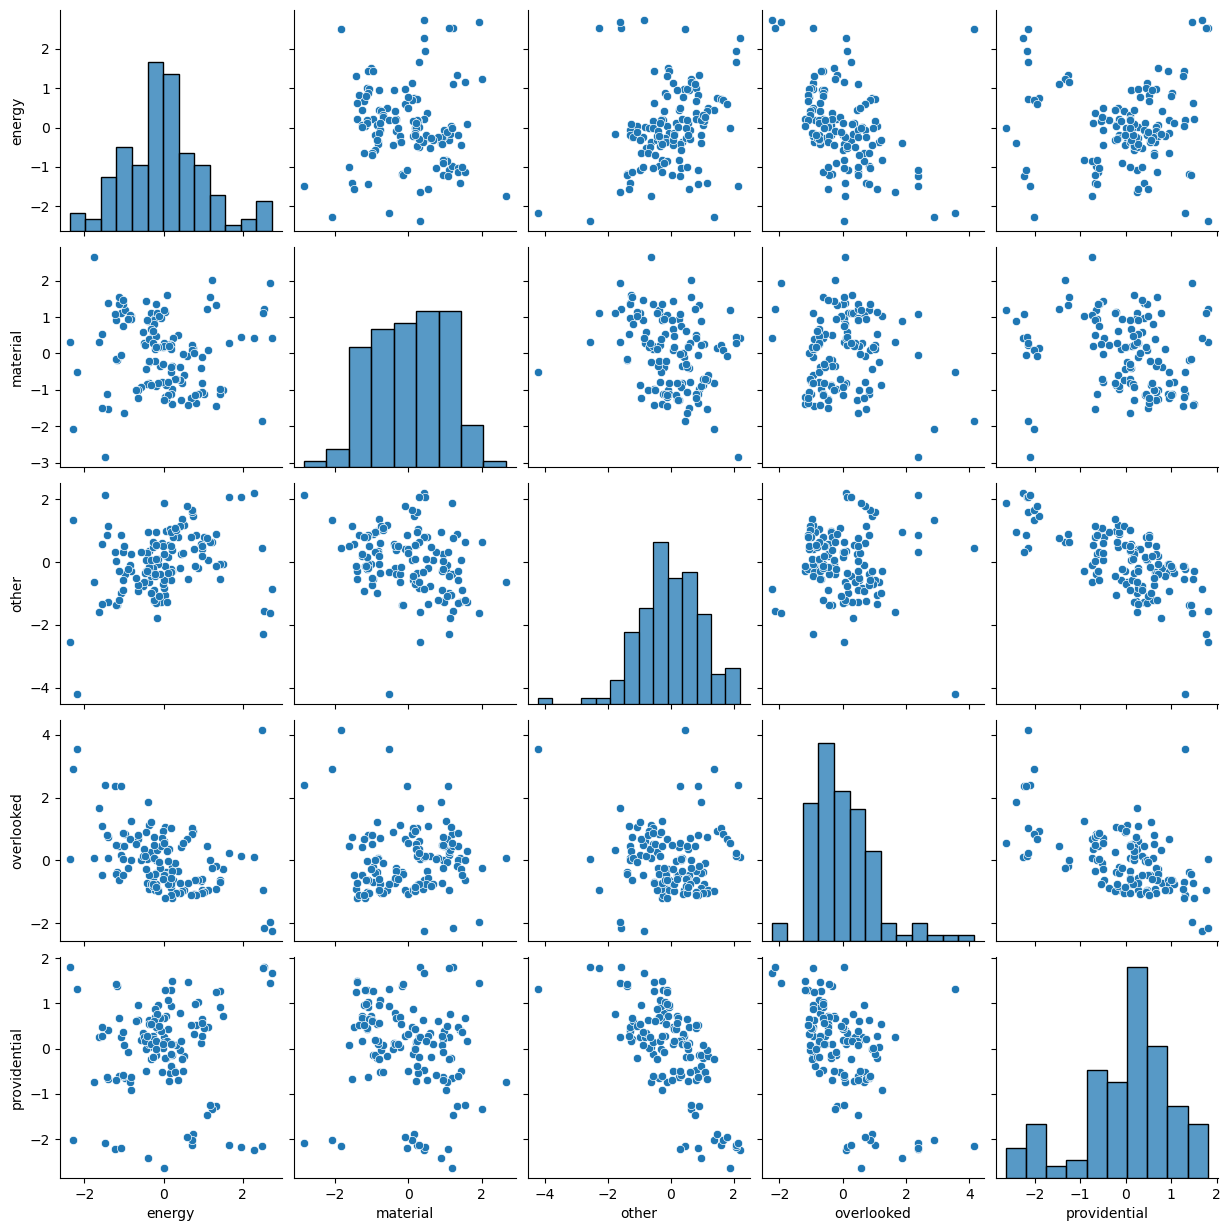

In [265]:
sns.pairplot(foundational_df_transformed[["energy", "material", "other", "overlooked", "providential"]])

Looks like there mostly isn't an exact linear relationship between independent variables.
Combination of providential + other and providential + overlooked looks suspicious though, should avoid putting them into one regression.
Overlooked vs energy also looks suspicious, maybe it makes sense to exclude Overlooked from the regression entirely.